# exp002
予測モデルのベースライン

In [1]:
import os
import sys
import gc
import random
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify

In [2]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [3]:
@dataclass
class Cfg:
    exp_name = "exp002"
    seed = 42
    k = 20
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week4"
    valid_session_n = 1_000_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
random.seed(cfg.seed)

In [4]:
@noglobal
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.6
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [5]:
class Candidate:
    def __init__(self, pdf, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid"], dtype=int)
        self.labels = labels

    def _entry(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df])
        self.output = self.output.drop_duplicates()

        if self.labels is not None:
            self._eval(new_candidate_df, name, k)

    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        print(name)
        print(eval_result)
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].replace(trans_map)
            
        self._entry(candidate_df, name, k)

    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [6]:
@noglobal
def add_labels(df, labels, type_):
    type_labels = labels[["session", f"{type_}_labels"]].dropna().copy()
    type_labels.columns = ["session", "aid"]
    type_labels = type_labels.explode("aid")
    type_labels["labels"] = 1
    df = df.merge(type_labels, on=["session", "aid"], how="left")
    df["labels"] = df["labels"].fillna(0)
    return df    

In [7]:
@noglobal
def add_ground_truth_candidate(df, labels, type_):
    gt = labels[["session", f"{type_}_labels"]].dropna().copy()
    gt.columns = ["session", "aid"]
    gt = gt.explode("aid")
    df = pd.concat([df, gt])
    df = df.drop_duplicates()
    return df

In [8]:
@noglobal
def under_sampling(df, label_col):
    cfg = Cfg()
    pos_df = df[df[label_col]==1].copy()
    neg_df = df[df[label_col]==0].copy()
    pos_n = len(pos_df)
    return pd.concat([pos_df, neg_df.sample(pos_n, random_state=cfg.seed)])

In [9]:
class AddFeatures:
    def __init__(self, sessions, candidate):
        cfg = Cfg()
        self.sessions = cudf.from_pandas(sessions)
        self.output = candidate
        self.type_dict = cfg.type2id

    def add_features(self, features_name):
        if features_name == "session_cnt":
            self._session_cnt()
        elif features_name == "session_aid_nunique":
            self._session_aid_nunique()
        elif features_name == "session_last_type":
            self._session_last_type()
        elif features_name == "aid_cnt":
            self._aid_cnt()
        
    def _session_cnt(self):
        agg_df = self.sessions.groupby(["session", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})
        # session_total_cnt
        features = agg_df.groupby("session")["cnt"].sum().reset_index().rename(columns={"cnt": "session_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_total_cnt"] = self.output["session_total_cnt"].fillna(0)
        # session_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"session_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)

    def _session_aid_nunique(self):
        features = self.sessions.groupby("session")["aid"].nunique().reset_index().rename(columns={"aid": "session_aid_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_aid_nunique"] = self.output["session_aid_nunique"].fillna(0)
        
    def _session_last_type(self):
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "type"]]
        features = features.rename(columns={"type": "session_last_type"})
        features["session_last_type"] = features["session_last_type"].map(self.type_dict)
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")

    def _aid_cnt(self):
        agg_df = self.sessions.groupby(["session", "aid", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})

        # aid_total_cnt
        features = agg_df.groupby(["session", "aid"])["cnt"].sum().reset_index().rename(columns={"cnt": "aid_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
        self.output["aid_total_cnt"] = self.output["aid_total_cnt"].fillna(0)

        # aid_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"aid_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", "aid", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)     

In [10]:
@noglobal
def make_cand_df(sessions, labels=None):
    if labels is not None:
         cand = Candidate(sessions)
    else:
        cand = Candidate(sessions, labels)
    cand.add(strategy="session_frequent", name="session_frequent")
    cand.add(strategy="total_frequent", name="total_frequent")
    return cand.output

@noglobal
def add_features(sessions, cand_df):
    feat = AddFeatures(sessions, cand_df)
    feat.add_features("session_cnt")
    feat.add_features("session_aid_nunique")
    feat.add_features("session_last_type")
    feat.add_features("aid_cnt")
    return feat.output.copy()

# trainデータ作成

In [11]:
report = f"\n{cfg.exp_name}\n"
report += f'train_start\n'
line_notify.send(report)

In [12]:
train_weeks = cfg.train_weeks
train_session_ids = []
dfs = []
for weeks in train_weeks:
    # データ読み込み
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{weeks}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{weeks}.pkl")
    train_session_ids.extend(week_sessions["session"].unique().tolist())

    for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):
        # 候補選出
        cand_df = make_cand_df(week_sessions)

        # 正解追加・under sampling
        cand_df = add_ground_truth_candidate(cand_df, week_labels, type_)
        cand_df = add_labels(cand_df, week_labels, type_)
        cand_df = under_sampling(cand_df, "labels")

        # 特徴量付与
        train_tmp = add_features(week_sessions, cand_df)
        train_tmp["type"] = type_int
        del cand_df
        gc.collect()
        dfs.append(train_tmp)
train = pd.concat(dfs)
train = train.reset_index(drop=True)
train_session_ids = list(set(train_session_ids))

del dfs, week_sessions, week_labels
gc.collect()

0

# validデータ作成

In [13]:
valid_week = cfg.valid_week
dfs = []

# データ読み込み
week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
valid_session_ids = week_sessions["session"].unique().tolist()

# validに使うsessionを絞る (trainに存在するsessionを除外した上で設定した数に絞る)
valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
valid_session_ids = random.sample(valid_session_ids, valid_session_n)
week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()

for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):
    # 候補選出
    cand_df = make_cand_df(week_sessions)

    # ラベル付与
    cand_df = add_labels(cand_df, week_labels, type_)
    
    # 特徴量付与
    train_tmp = add_features(week_sessions, cand_df)
    train_tmp["type"] = type_int
    del cand_df
    gc.collect()

    dfs.append(train_tmp)
valid = pd.concat(dfs)
valid = valid.reset_index(drop=True)

del dfs, week_sessions
gc.collect()

0

# 学習

In [14]:
target = "labels"
not_use_cols = ["session", "aid", target]
features = [c for c in train.columns if c not in not_use_cols]

In [15]:
params = {
   'objective': 'binary',
   'boosting': 'gbdt',
   'learning_rate': 0.1,
   'metric': 'binary_logloss',
   'seed': cfg.seed
}

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 7353585, number of negative: 7353585
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.488006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 14707170, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.601585	valid_1's binary_logloss: 0.548002
[2000]	training's binary_logloss: 0.60087	valid_1's binary_logloss: 0.54758
[3000]	training's binary_logloss: 0.600287	valid_1's binary_logloss: 0.547345
Early stopping, best iteration is:
[3811]	training's binary_logloss: 0.599867	valid_1's binary_logloss: 0.5472
{'num_clicks': 971881, 'hit_clicks': 278123, 'num_carts': 431700, 'hit_carts': 7785

40

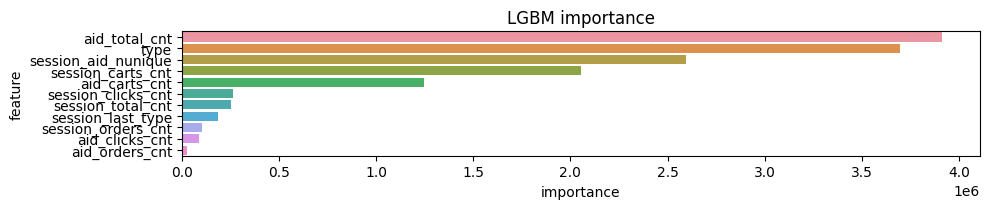

In [16]:
# 学習
vl_pred_df = valid[["session", "aid", "type"]].copy()

tr_x, tr_y = train[features], train[target]
vl_x, vl_y = valid[features], valid[target]
tr_data = lgb.Dataset(tr_x, label=tr_y)
vl_data = lgb.Dataset(vl_x, label=vl_y)

model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                  num_boost_round=200000, early_stopping_rounds=100, verbose_eval=1000)

# 特徴量重要度
fi = pd.DataFrame()
fi["feature"] = model.feature_name()
fi["importance"] = model.feature_importance(importance_type="gain")

# 2値分類の出力を元にk個選定
vl_pred_df["prob"] = model.predict(vl_x, num_iteration=model.best_iteration)
vl_pred_df = vl_pred_df.sort_values(["session", "type", "prob"], ascending=(True, True, False))
vl_pred_df = vl_pred_df.groupby(["session", "type"]).head(cfg.k)
vl_pred_df = vl_pred_df.groupby(["session", "type"])["aid"].apply(list).reset_index()
vl_pred_df["type"] = vl_pred_df["type"].replace(cfg.id2type)

# 評価
assert week_labels["session"].tolist() == vl_pred_df["session"].unique().tolist()
score = evaluate(week_labels["clicks_labels"].tolist(),
                 week_labels["carts_labels"].tolist(),
                 week_labels["orders_labels"].tolist(),
                 vl_pred_df[vl_pred_df["type"]=="clicks"]["aid"].tolist(),
                 vl_pred_df[vl_pred_df["type"]=="carts"]["aid"].tolist(),
                 vl_pred_df[vl_pred_df["type"]=="orders"]["aid"].tolist(),
                 cfg.k)
print(score)

# モデル保存
model.save_model(cfg.output_dir + f"{cfg.exp_name}/model.lgb")

# 特徴量重要度
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

del train, valid, tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
del vl_pred_df, model
gc.collect()

In [17]:
report = f"\n{cfg.exp_name}\n"
report += f'valid_end\n'
report += str(score)
line_notify.send(report)

# sub

In [40]:
# testデータ作成
test_sessions = pd.read_pickle(cfg.prep_dir + f"test_sessions.pkl")

dfs =[]
for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):
    # 候補選出
    cand_df = make_cand_df(test_sessions)
    # 特徴量付与
    train_tmp = add_features(test_sessions, cand_df)
    train_tmp["type"] = type_int
    del cand_df
    gc.collect()

    dfs.append(train_tmp)
test = pd.concat(dfs)
test = test.reset_index(drop=True)

del dfs, test_sessions
gc.collect()

0

In [41]:
# 推論
model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/model.lgb")

# 2値分類の出力を元にk個選定
test["prob"] = model.predict(test[features], num_iteration=model.best_iteration)
test = test.sort_values(["session", "type", "prob"], ascending=(True, True, False))
test = test.groupby(["session", "type"]).head(cfg.k)
test["aid"] = test["aid"].astype(str)
test = test.groupby(["session", "type"])["aid"].apply(list).reset_index()
test["aid"] = test["aid"].apply(lambda x: ' '.join(x))
test["type"] = test["type"].replace(cfg.id2type)

# sub作成
sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
test["session_type"] = test["session"].astype(str) + "_" + test["type"]
test = test.rename(columns={"aid": "labels"})
sub = sub.merge(test[["session_type", "labels"]], on="session_type", how="left")
sub.to_csv(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_sub.csv", index=False)
sub.head(20)

,session_type,labels
0,12899779_clicks,59625 485256 1460571 108125 986164 554660 1551...
1,12899779_carts,59625 485256 1460571 108125 986164 554660 1551...
2,12899779_orders,59625 485256 1460571 108125 986164 554660 1551...
3,12899780_clicks,1142000 582732 736515 973453 485256 1460571 10...
4,12899780_carts,1142000 582732 736515 973453 485256 1460571 10...
5,12899780_orders,1142000 582732 736515 973453 485256 1460571 10...
6,12899781_clicks,199008 57315 141736 194067 918667 485256 14605...
7,12899781_carts,199008 57315 141736 194067 918667 485256 14605...
8,12899781_orders,199008 57315 141736 194067 918667 485256 14605...
9,12899782_clicks,127404 479970 834354 779477 595994 829180 1669...


In [42]:
report = f"\n{cfg.exp_name}\n"
report += f'inf_end\n'
line_notify.send(report)